In [1]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import controller

In [2]:
ctrl = controller.controller()

In [3]:
Q = np.array(
    [
        [0,0,0,0],
        [0,900.,0,30],
        [0,0,0,0],
        [0,30,0,1]
    ]
)
R = 10.*np.eye(2) 
F = Q 

ctrl.set_cost(Q,R,F)

In [4]:
CL = 2
def matrix_iterator(x0,u0):
    A = np.array([
        [0,    0,  (-np.sin(x0[2])*x0[3])[0],   (np.cos(x0[2]))[0]],
        [0,    0,  (np.cos(x0[2])*x0[3])[0],    (np.sin(x0[2]))[0]],
        [0,    0,  0,                      (np.tan(u0[1])/CL)[0]],
        [0,0,0,0]
    ]
    )

    B = np.array(
        [
        [0,0],
        [0,0],
        [0, (x0[3]/(np.cos(u0[1])**2 * CL))[0]],
        [0.5,0]
        ]
    )

    f0 = np.array([
        [(np.cos(x0[2])*x0[3])[0]],
        [(np.sin(x0[2])*x0[3])[0]],
        [((np.tan(u0[1])/CL)*x0[3])[0]],
        [(0.5*u0[0])[0]]
    ])

    return A,B,f0

x0 = np.array(
    [
        [0],
        [3.],
        [0],
        [20]
    ]
)

xd = np.array(
    [
        [0],
        [0.],
        [0],
        [20]
    ]
)

u0 = np.array(
    [
        [0],
        [0]
    ]
)


In [10]:
ctrl.pred_horizon = 30
xlist = [x0]
ulist = [u0]
for i in range(2):
    A,B,f0 = matrix_iterator(x0,u0)
    ctrl.update_dynamics(A,B,f0)
    ctrl.discretize(0.1)
    ctrl.setup_qp_linear(x0,u0,xd)
    u = ctrl.solve_qp(x0)
    u0 = u[0:2].reshape(-1,1)
    x0 = ctrl.apply_control(x0,u0)
    xlist.append(x0)
    ulist.append(u0)
    #print('stepped')


In [11]:
import matplotlib.pyplot as plt

In [12]:
xm = np.array(xlist).squeeze(-1)
print(xm.shape)

(3, 4)


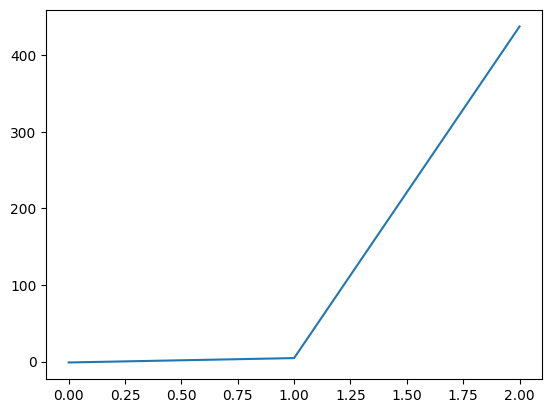

In [13]:
plt.plot(xm[0:10,1])

In [10]:
u_tilde = u.reshape(-1,2)

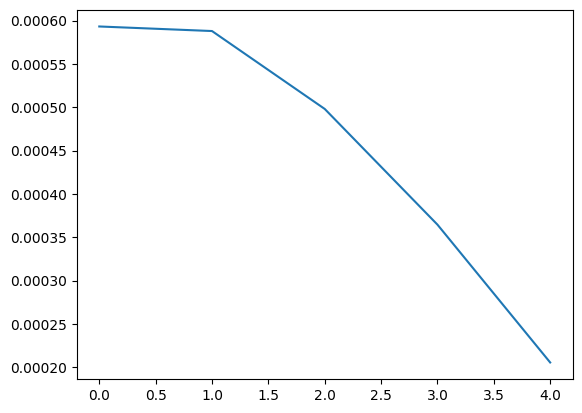

In [11]:
plt.plot(u_tilde[:,0])

In [12]:
u_tilde[6,0]

IndexError: index 6 is out of bounds for axis 0 with size 5